# M-Lab Data Analysis Notebook

An autonomous system number (ASN) is a unique number assigned to an autonomous system(AS) by the Internet Assigned Numbers Authority (IANA).

An AS consists of blocks of IP addresses which have a distinctly defined policy for accessing external networks and are administered by a single organization but may be made up of several operators.

IPs of Starlink User Terminals have the ASN of `14593`

Also see:
- https://www.peeringdb.com/net/18747
- https://www.measurementlab.net/data/

In [1]:
from matplotlib import font_manager
font_manager_list = font_manager.fontManager

In [2]:
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geohash
import cartopy.crs as ccrs
from datetime import datetime
import geohash
import geopandas
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
from matplotlib import colors
from descartes import PolygonPatch
from unidecode import unidecode
from matplotlib.patches import Patch
from unidecode import unidecode
import os
import shutil

# Helper Functions
%load_ext autoreload
%autoreload 2
from plot_utils import plot_cdf, plot_probe_map, plot_boxplot_progression

# Setting global font to "CMU Sans Serif"
from matplotlib import rcParams
rcParams["font.family"] = "CMU Sans Serif"

# Color Style Definitions
continents = ["AF", "AS", "EU", "NA", "OC", "SA"]
cols = plt.get_cmap("tab10").colors
lstyle_array = ["solid", "dotted", "dashed", "dashdot"]

# Latex needs to be available in order to build the exact plots we used in the paper
plt.rc('text', usetex=True if shutil.which('latex') else False)

We are using the [BigQuery interface](https://console.cloud.google.com/bigquery?project=measurement-lab&pli=1) to get the M-Lab data. The query results are hosted in in a [MediaTUM](https://mediatum.ub.tum.de/) server. Each `*.csv` file corresponds to the result of a `*.sql` file found in the `mlab_queries` folder.

---

**Why not use the API?**

Because of this ([source](https://www.measurementlab.net/data/docs/bq/quickstart/)):

> [...] Because of the means by which M-Lab must whitelist query users, we cannot guarantee that no charges will be incurred by applications using service accounts which query M-Lab datasets, tables, and views.

## Scraping Data

There are two kinds of information we scrape:

* Starlink availability from Wikipedia
* Crowdsourced Starlink Groundstation / PoP locations


> Why scraping from wikipedia and not from the starlink website directly?

To the best of our knowledge, there is no direct way to get access on a list of accessibility of a country. The [website](https://www.starlink.com/map) shows a map of availabilities, but not a directly scrapeable list. Api endpoints of [prices.json](https://api.starlink.com/public-files/prices.json) shows prices for each country and api endpoint [coverage_residential.json](https://api.starlink.com/public-files/coverage_residential.json) shows, We are assuming, polygon data for the map rendering of availabilities. Getting the country name form the polygon data is non-trivial and the prices list do not guarantee that Starlink is in fact available in that country, only that there exists a price out there.

In [3]:
from bs4 import BeautifulSoup
import requests

response = requests.get("https://en.wikipedia.org/wiki/Starlink")
soup = BeautifulSoup(response.text)

countries_soup = soup.find_all("table", attrs={"class": "wikitable"})[1]

countries = []
for a in countries_soup.find_all("tr")[1:]:
    for b in a.find_all("td")[2].find_all("a"):
        countries.append(b.text)
countries.sort()
countries.remove("Czech Republic")
countries.append("Czechia")
countries.remove("United States Virgin Islands")
countries.append("U.S. Virgin Islands")

with open(f"scraped_data/starlink_countries_{datetime.now().strftime('%Y-%m-%d')}.csv", "w") as f:
    f.write("\n".join(countries))

> Where do we get the Groundstation / PoP locations from?

We scrape gateway information from https://www.google.com/maps/d/u/0/viewer?mid=1805q6rlePY4WZd8QMOaNe2BqAgFkYBY&ll=-12.088950899999976%2C-76.9731775&z=8

To scrape it, run this:

```bash
wget "https://www.google.com/maps/d/u/0/kml?mid=1805q6rlePY4WZd8QMOaNe2BqAgFkYBY&forcekml=1" -O scraped_data/Gateways_PoPs_n_Backbone_$(date '+%Y-%m-%d').kml
```

For reproducability, we provide the scraped data for early October 2023 in the `scraped_data` folder. You can change the used `Gateways_PoPs_n_Backbone.kml` or `starlink_countries_*.csv` file for more up-to-date scraped information.

## Loading the .csv and scraped data files into Pandas Dataframes

In [4]:
# data_path = os.path.os.getenv("DATA_PATH", "/u/halle/renatin/home_at/starlink_paper_data")
# mlab_data_path = os.path.join(data_path, "mlab")

# Read the location of the dataset and create the results directory
try:
    result_path = os.path.join(os.environ["RESULT_PATH"], "mlab")
    os.makedirs(result_path, exist_ok=True)

    # Use the os.environ dictionary to access the value
    mlab_data_path = os.path.join(os.environ["DATA_PATH"], "mlab")
except Exception as e:
    print("DATA_PATH and RESULT_PATH needed")
    raise e

In [6]:
# Retrieving Datasets as dataframes
ndt7_df   = pd.read_csv(os.path.join(mlab_data_path, "cities_overview.csv")).set_index("ClientGeohash")
ndt7_df = ndt7_df.sort_values(by="MeasurementCount", ascending=False)
ndt7_df["lat"] = [geohash.decode(gh)[0] for gh in ndt7_df.index]
ndt7_df["lon"] = [geohash.decode(gh)[1] for gh in ndt7_df.index]

In [7]:
csvs = [
    "city_filtered1_2022-06-01.csv",
    "city_filtered1_2023-10-01.csv",
    "city_filtered2_2022-06-01.csv",
    "city_filtered2_2023-02-01.csv",
    "city_filtered2_2023-10-01.csv",
    "city_filtered3_2022-06-01.csv",
    "city_filtered3_2023-10-01.csv",
    "city_filtered4.csv",
    "city_filtered5.csv",
    "city_filtered6.csv",
    "city_filtered8.csv",
]

city_df = pd.concat([pd.read_csv(os.path.join(mlab_data_path, csvpath)) for csvpath in csvs])

def convert_date(datestr):
    try:
        return datetime.strptime(datestr, '%Y-%m-%d %H:%M:%S.%f %Z')
    except ValueError:
        return datetime.strptime(datestr, '%Y-%m-%d %H:%M:%S %Z')
city_df["a_TestTime"]  = city_df["a_TestTime"].apply(convert_date)
city_df["a_TestMonth"] = city_df["a_TestTime"].apply(lambda date: datetime(year=date.year, month=date.month, day = 1))
city_df["a_DiffRTT"] = city_df["a_MaxRTT"] - city_df["a_MinRTT"]

city_df = city_df[city_df["a_MinRTT"] < 2000] # Discarding outliers. Arbitrary chosen limit of 2000 ms

/tmp/ipykernel_616963/511804533.py:15: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  city_df = pd.concat([pd.read_csv(os.path.join(mlab_data_path, csvpath)) for csvpath in csvs])
/tmp/ipykernel_616963/511804533.py:15: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  city_df = pd.concat([pd.read_csv(os.path.join(mlab_data_path, csvpath)) for csvpath in csvs])
/tmp/ipykernel_616963/511804533.py:15: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  city_df = pd.concat([pd.read_csv(os.path.join(mlab_data_path, csvpath)) for csvpath in csvs])
/tmp/ipykernel_616963/511804533.py:15: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  city_df = pd.concat([pd.read_csv(os.path.join(mlab_data_path, csvpath)) for csvpath in csvs])


In [8]:
# Defining Regions

def filter_na(ddf, linktype="down"):
    lon_bound = (-130, -63.6)
    lat_bound = (25, 52)
    
    ddf = ddf[
            ((ddf["client_Geo_Latitude"] > lat_bound[0]) & (ddf["client_Geo_Latitude"] < lat_bound[1])) &
            ((ddf["client_Geo_Longitude"] > lon_bound[0]) & (ddf["client_Geo_Longitude"] < lon_bound[1]))
        ]
    ddf = ddf[ddf["client_Geo_City"].map(unidecode) == ddf["server_Geo_City"].map(unidecode)]
    if linktype == "down":
        ddf = ddf[ddf["isDownload"] == True]
    elif linktype == "up":
        ddf = ddf[ddf["isDownload"] == False]
    
    return ddf

def filter_sa(ddf, linktype="down"):
    lon_bound = (-90, -34)
    lat_bound = (-57.46, 12)

    ddf = ddf[
            ((ddf["client_Geo_Latitude"] > lat_bound[0]) & (ddf["client_Geo_Latitude"] < lat_bound[1])) &
            ((ddf["client_Geo_Longitude"] > lon_bound[0]) & (ddf["client_Geo_Longitude"] < lon_bound[1]))
        ]
    ddf = ddf[ddf["client_Geo_CountryCode"] == ddf["server_Geo_CountryCode"]]
    if linktype == "down":
        ddf = ddf[ddf["isDownload"] == True]
    elif linktype == "up":
        ddf = ddf[ddf["isDownload"] == False]
        
    return ddf

def filter_eu(ddf, linktype="down"):
    lon_bound = (-13, 40)
    lat_bound = (35, 72)
    
    ddf = ddf[
            ((ddf["client_Geo_Latitude"] > lat_bound[0]) & (ddf["client_Geo_Latitude"] < lat_bound[1])) &
            ((ddf["client_Geo_Longitude"] > lon_bound[0]) & (ddf["client_Geo_Longitude"] < lon_bound[1]))
        ]
    ddf = ddf[ddf["client_Geo_CountryCode"] == ddf["server_Geo_CountryCode"]]
    if linktype == "down":
        ddf = ddf[ddf["isDownload"] == True]
    elif linktype == "up":
        ddf = ddf[ddf["isDownload"] == False]
        
    return ddf

def filter_au(ddf, linktype="down"):
    lon_bound = (110, 180)
    lat_bound = (-48.2, -10)

    ddf = ddf[
            ((ddf["client_Geo_Latitude"] > lat_bound[0]) & (ddf["client_Geo_Latitude"] < lat_bound[1])) &
            ((ddf["client_Geo_Longitude"] > lon_bound[0]) & (ddf["client_Geo_Longitude"] < lon_bound[1]))
        ]
    ddf = ddf[((ddf["server_Geo_City"].map(unidecode) == "Sydney") & (ddf["client_Geo_CountryCode"].map(unidecode) == "AU")) | (ddf["client_Geo_CountryCode"].map(unidecode) == ddf["server_Geo_CountryCode"].map(unidecode))]
    if linktype == "down":
        ddf = ddf[ddf["isDownload"] == True]
    elif linktype == "up":
        ddf = ddf[ddf["isDownload"] == False]
        
    return ddf

def filter_mx(ddf, linktype="down"):
    lon_bound = (-118.2,-50)
    lat_bound = (8.3, 28)

    ddf = ddf[
            ((ddf["client_Geo_Latitude"] > lat_bound[0]) & (ddf["client_Geo_Latitude"] < lat_bound[1])) &
            ((ddf["client_Geo_Longitude"] > lon_bound[0]) & (ddf["client_Geo_Longitude"] < lon_bound[1]))
        ]
    if linktype == "down":
        ddf = ddf[ddf["isDownload"] == True]
    elif linktype == "up":
        ddf = ddf[ddf["isDownload"] == False]
        
    return ddf

region_filters = {
    "NA": filter_na,
    "SA": filter_sa,
    "EU": filter_eu,
    "AU": filter_au,
    "MX": filter_mx
}

In [9]:
country_perf_down_df = pd.read_csv(os.path.join(mlab_data_path, "mlab_starlink_down_country_agg.csv"))
country_perf_down_df.set_index("CountryName", inplace=True)
country_perf_up_df = pd.read_csv(os.path.join(mlab_data_path, "mlab_starlink_up_country_agg.csv"))
country_perf_up_df.set_index("CountryName", inplace=True)

country_agg_topmno_df = pd.read_csv(os.path.join(mlab_data_path, "mlab_mnocell_all_diagnostic.csv"))
country_agg_sl_df = pd.read_csv(os.path.join(mlab_data_path, "mlab_starlink_country_agg.csv"))

In [10]:
# Retrieving Starlink Availability scraped from wikipedia or loading from .csv
from bs4 import BeautifulSoup
import requests

def load_countries(data_path="scraped_data/starlink_countries_2023-10-10.csv"):
    with open(data_path, "r") as f:
        countries_str = f.read()
    countries = [country_str.strip() for country_str in countries_str.split("\n") if len(country_str.strip()) > 0]
    
    return countries

countries = load_countries()

import pycountry
# Mapping a country name to its country code
countries_map = {}
for country in pycountry.countries:
    countries_map[country.name] = country.alpha_2

countries_code = [countries_map.get(country, 'Unknown code') for country in countries]

In [11]:
# Traceroute & Throughput

trace_tput_df = pd.read_csv(os.path.join(mlab_data_path, "traceroute_join_countrycity.csv"))

def apply_str_to_list(s: str):
    s = s[1:-1]
    l = [float(num.strip()) for num in s.split(",")]
    return l

def apply_extract_median(arr: list):
    return arr[len(arr)//2]

trace_tput_df["stl_rtt_fraction"] = trace_tput_df["stl_rtt_fraction"].apply(apply_str_to_list)
trace_tput_df["stl_rtt"] = trace_tput_df["stl_rtt"].apply(apply_str_to_list)
trace_tput_df["median_stl_rtt"] = trace_tput_df["stl_rtt"].apply(apply_extract_median)
trace_tput_df["median_stl_rtt_fraction"] = trace_tput_df["stl_rtt_fraction"].apply(apply_extract_median)
trace_tput_df = trace_tput_df[trace_tput_df["countryC"].isin(countries_code)]
#trace_tput_df.sort_values("cnt", ascending=False)

### Loading PoPs and Gateways

In [12]:
from bs4 import BeautifulSoup

def process_kml(file_path):
    with open(file_path, "r") as f:
        kml_str = f.read()
    soup = BeautifulSoup(kml_str, "xml")
    return soup

file_path = "./scraped_data/Gateways_PoPs_n_Backbone_2023-10-10.kml"

soup = process_kml(file_path)

In [13]:
import pandas as pd

gateway_locs = []
for f in soup.find_all("Folder"):
    if(f.find("name").text == "PoPs & Backbone"):
        continue
    continent = f.find("name").text
    for pm in f.find_all("Placemark"):
        gateway_locs.append((continent, pm))

def parse_pm_gw(continent, pm):
    d = {}
    lat, lon = pm.find("Data", attrs={"name" : "Coords"}).find("value").text.split(",")
    lat = float(lat.strip())
    lon = float(lon.strip())
    d["continent"] = continent
    d["lat"] = lat
    d["long"] = lon
    return d
    
gateway_locs = [parse_pm_gw(cont, gl) for (cont, gl) in gateway_locs]
gateway_df = pd.DataFrame(gateway_locs)

In [14]:
pop_locs = []
for f in soup.find_all("Folder"):
    if(f.find("name").text != "PoPs & Backbone"):
        continue
    for pm in f.find_all("Placemark"):
        if(f.find("styleUrl").text != "#icon-1609-0288D1"):
            continue
        #print(pm)
        if(pm == None):
            print(f)
            continue
        if("<->" in pm.find("name").text):
            continue
        pop_locs.append(pm)

def parse_pm_pop(pm):
    d = {}
    #print(pm.find("coordinates").text.split(","))
    coordinates = pm.find("coordinates").text.split(",")
    lat = float(coordinates[1].strip())
    lon = float(coordinates[0].strip())
    d["lat"] = lat
    d["long"] = lon
    d["name"] = pm.find("name").text
    d["description"] = pm.find("name").text
    return d
    
pop_locs = [parse_pm_pop(pl) for pl in pop_locs]
pop_df = pd.DataFrame(pop_locs)

## Style Definition

In [15]:
def assign_style(cityname):
    cols = plt.get_cmap("tab10").colors
    linestyle_array = ['solid', 'dotted', 'dashed', 'dashdot']
    
    offsetcolor = 0
    offsetline = 0
    
    if cityname == "New York":
        offsetcolor = -1
    elif cityname == "Seattle":
        offsetcolor = 2
    elif cityname == "Mexico City":
        offsetcolor = 1
    elif cityname == "Lima":
        offsetcolor = 2
        offsetline = 2
    elif cityname == "Paris":
        offsetcolor = 1
        offsetline = 12
    elif cityname == "London":
        offsetcolor = 2
        offsetline = 3
    elif cityname == "Perth":
        offsetcolor = 2
        offsetline = 3
    elif cityname == "Bororen":
        offsetcolor = 1
        offsetline = 12
    
    return cols[(offsetcolor + abs(hash(cityname))) % len(cols)], linestyle_array[(offsetline + abs(hash(cityname))) % len(linestyle_array)]

cities = city_df["client_Geo_City"].drop_duplicates().values
city_colors = {city: assign_style(city)[0] for city in city_df["client_Geo_City"].drop_duplicates().values}
lstyles = {city: assign_style(city)[1] for city in city_df["client_Geo_City"].drop_duplicates().values}
cols = plt.get_cmap("tab10").colors

## Total Aggregated Numbers

In [16]:
country_agg_sl_df = pd.read_csv(os.path.join(mlab_data_path, "mlab_starlink_country_agg.csv"))

used_df = country_agg_sl_df[country_agg_sl_df["count_measurements"] > 1000].reset_index()
used_df = used_df[used_df["CountryName"].isin(countries)]
print("Totally considered number of countries:", len(set(used_df["CountryName"])))
print("Total number of samples considers:", used_df["count_measurements"].sum())

Totally considered number of countries: 34
Total number of samples considers: 19233787


## IP Geolocation spread

The spread of IP geolocation is not even. In the next cell, we see that only the US, Australia, Canada, Mexico and Belgium have more than one cities geolocated by the IP annotator. I never got around to inspect the MLAB IP annotator.

In [17]:
temp_df = ndt7_df.groupby(["ClientCountry", "ClientCity"])[["MeasurementCount"]].sum()
distinct_city_per_country_df = temp_df.reset_index().groupby(["ClientCountry"])[["ClientCity"]].count().sort_values(by="ClientCity", ascending=False)

distinct_city_per_country_df.iloc[:10]

,ClientCity
ClientCountry,
United States,83
Australia,54
Canada,16
Mexico,4
Belgium,2
Nigeria,1
Poland,1
Philippines,1
Peru,1


Because most of the time, there is only one city geolocated for the IP addresses, rather than talking about "Cities", we talk about "Regions" or "Countries". If we are discussing a city in a country where there are multiple distinct cities geolocated, like Australia or the US, then we use a label format like `US-Seattle`. In all other cases, we use the countryname. This mapping is done manually in the map below:

In [18]:
LABELMAPRULE = {
    "Dublin": "Ireland",
    "Seattle": "US-Seattle",
    "Lagos": "Nigeria",
    "Sydney": "AU-Sydney",
    "Manila": "Philippines",
    "São Paulo": "Brazil",
    "Mexico City": "Mexico",
    "Berlin": "Germany",
    "Paris": "France",
    "Rome": "Italy",
    "London": "UK",
    "Bogotá": "Colombia",
    "Santiago": "Chile",
    "Lima": "Peru",
    "Dallas": "US-Dallas",
    "New York": "US-New York",
    "Denver": "US-Denver",
    "Los Angeles": "US-Los Angeles",
    "Auckland": "AU-Auckland",
    "Perth": "AU_Perth",
    "Kellevie": "AU-Kellevie",
    "Noojee": "AU-Noojee"
}

## RTT CDFs

* Figure 6:  Starlink latency distribution from select cities in each continent
* Figure 7: Distributions of M-Lab minRTTs over Starlink from select cities in Europe and South America, respectively.
* Figure 8: RTT inflation (maxRTT-minRTT) during M-Lab speedtests over Starlink in each continent: (a) download, (b) upload traffic
* Figure 9: Distribution of median (a) download and (b) upload goodput over Starlink from selected cities globally.
* Figure 19:  Comparing median minRTT from tests originating in Manila that targeted M-Lab servers in the Philippines and in Japan.
* Figure 20: The TCP packet loss rates during M-Lab download tests of selected global cities
* Figure 21:  The distribution of the minimum RTT (minRTT) during M-Lab measurements from selected cities in North America (a) and Oceania (b)

### Figure 6

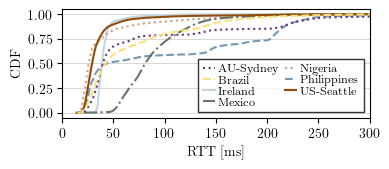

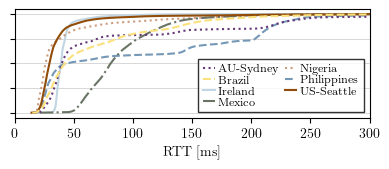

In [60]:
interesting_cities = [
        "Mexico City",
        "São Paulo",
        "Seattle",
        "Sydney",
        "Dublin",
        "Lagos",
        "Manila"
]
interesting_cities=sorted(interesting_cities)
city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}
lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

df = city_df[ 
    city_df["client_Geo_City"].isin(interesting_cities)
]

# Filter out not same city / country
from unidecode import unidecode
df = df[((df["client_Geo_City"].map(unidecode) == df["server_Geo_City"].map(unidecode)) & df["client_Geo_CountryCode"].isin(["US", "AU"])) | (df["client_Geo_CountryCode"] == df["server_Geo_CountryCode"])]

down_df = df[df["isDownload"] == True]
up_df = df[df["isDownload"] == False]

matplotlib.rcParams.update({"font.size": 10})
plot_cdf(down_df, interesting_cities, "a_MinRTT", "RTT [ms]", 
             figsize=(4, 1.8), xlim=(0, 300), city_colors=city_colors, lstyles=lstyles, savefig="fig06_mlab_cdf_minrtt_globalcities.pdf", labelmaprule=LABELMAPRULE,
             figures_path=result_path)
plot_cdf(down_df, interesting_cities, "a_MinRTT", "RTT [ms]", 
             figsize=(4, 1.8), xlim=(0, 300), ylabel="", stripylabels=True, city_colors=city_colors, lstyles=lstyles, savefig="fig06_mlab_cdf_minrtt_globalcities_stripped.pdf", labelmaprule=LABELMAPRULE,
             figures_path=result_path)

### Figure 7

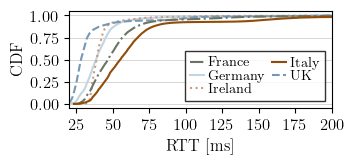

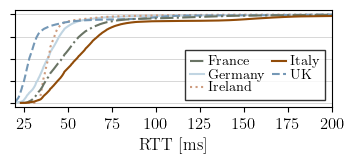

In [61]:
interesting_cities = [
                "Dublin",
                "London",
                "Berlin",
                "Paris",
                "Rome"]
interesting_cities = sorted(interesting_cities)

city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}

lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

df = region_filters["EU"](city_df)

matplotlib.rcParams.update({"font.size": 12})
plot_cdf(df, interesting_cities, "a_MinRTT", "RTT [ms]", xticks=[25, 50, 75, 100, 125, 150, 175, 200],
             figsize=(3.7, 1.8), city_colors=city_colors, lstyles=lstyles, savefig="fig07_mlab_cdf_minrtt_eucities.pdf", xlim=(20, 200), labelmaprule=LABELMAPRULE,
             figures_path=result_path)
plot_cdf(df, interesting_cities, "a_MinRTT", "RTT [ms]", xticks=[25, 50, 75, 100, 125, 150, 175, 200],
             figsize=(3.7, 1.8), city_colors=city_colors, lstyles=lstyles, savefig="fig07_mlab_cdf_minrtt_eucities_stripped.pdf", xlim=(20, 200), ylabel="", stripylabels=True, labelmaprule=LABELMAPRULE,
             figures_path=result_path)

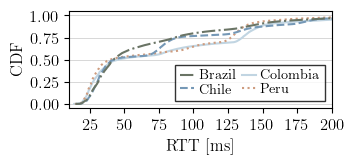

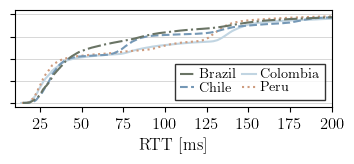

In [62]:
interesting_cities = [
                "São Paulo",
                "Santiago",
                "Bogotá",
                "Lima"]
interesting_cities = sorted(interesting_cities)

city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}

lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

df = region_filters["SA"](city_df)

matplotlib.rcParams.update({"font.size": 12})
plot_cdf(df[df["isDownload"] == True], interesting_cities, "a_MinRTT", "RTT [ms]", xticks=[25, 50, 75, 100, 125, 150, 175, 200],
             figsize=(3.7, 1.8), city_colors=city_colors, lstyles=lstyles, savefig="fig07_mlab_cdf_minrtt_5sacities.pdf", xlim=(10, 200), labelmaprule=LABELMAPRULE,
             figures_path=result_path)
plot_cdf(df[df["isDownload"] == True], interesting_cities, "a_MinRTT", "RTT [ms]", xticks=[25, 50, 75, 100, 125, 150, 175, 200],
             figsize=(3.7, 1.8), city_colors=city_colors, lstyles=lstyles, savefig="fig07_mlab_cdf_minrtt_5sacities_stripped.pdf", xlim=(10, 200), ylabel="", stripylabels=True, labelmaprule=LABELMAPRULE,
             figures_path=result_path)

### Figure 8

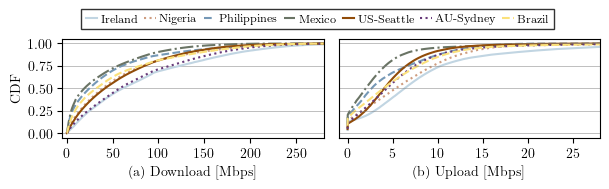

In [63]:
interesting_cities = [
        "Mexico City",
        "São Paulo",
        "Seattle",
        "Sydney",
        "Dublin",
        "Lagos",
        "Manila"
]
interesting_cities=sorted(interesting_cities)
city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}
lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

df = city_df[ 
    city_df["client_Geo_City"].isin(interesting_cities)
]

# Filter out not same city / country
from unidecode import unidecode
df = df[((df["client_Geo_City"].map(unidecode) == df["server_Geo_City"].map(unidecode)) & df["client_Geo_CountryCode"].isin(["US", "AU"])) | (df["client_Geo_CountryCode"] == df["server_Geo_CountryCode"])]

down_df = df[df["isDownload"] == True]
up_df = df[df["isDownload"] == False]

###########################

matplotlib.rcParams.update({"font.size": 10})

fig, axs = plt.subplots(1, 2, figsize=(6.2, 1.7))

plot_cdf(down_df, interesting_cities, "GoodputMedian", "(a) Download [Mbps]",
                  show=False, ax=axs[0], skiplegend=True,
             figsize=(5.2, 1.3), city_colors=city_colors, xlim=(-5, 280), lstyles=lstyles, labelmaprule=LABELMAPRULE)

plot_cdf(up_df,  interesting_cities, "GoodputMedian", "(b) Upload [Mbps]", 
                show=False, ax=axs[1], skiplegend=False,
             figsize=(5.2, 1.3), city_colors=city_colors, xlim=(-1, 28), lstyles=lstyles, labelmaprule=LABELMAPRULE)
axs[1].set_ylabel("")
axs[1].set_yticks([])
axs[0].grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.00, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.25, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.50, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.75, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(1.00, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
          fontsize="small", ncol=7, edgecolor="k", handlelength=1, labelspacing=0.06, bbox_to_anchor=(0.52, 1.12),
                  columnspacing=0.5, handletextpad=0.3, fancybox=False)

axs[1].get_legend().remove()

fig.tight_layout()
plt.savefig(os.path.join(result_path, "fig08_mlab_cdf_mediangoodput-both_globalcities.pdf"), bbox_inches="tight", pad_inches=0)
plt.savefig(os.path.join(result_path, "fig08_mlab_cdf_mediangoodput-both_globalcities.svg"), bbox_inches="tight", pad_inches=0)
plt.show()

###  Figure 9

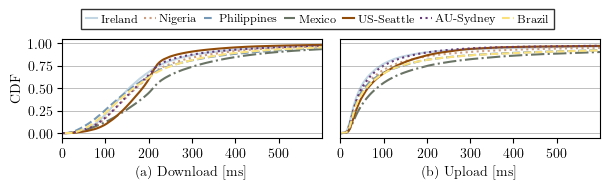

In [64]:
interesting_cities = [
        "Mexico City",
        "São Paulo",
        "Seattle",
        "Sydney",
        "Dublin",
        "Lagos",
        "Manila"
]
interesting_cities=sorted(interesting_cities)
city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}
lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

df = city_df[ 
    city_df["client_Geo_City"].isin(interesting_cities)
]

# Filter out not same city / country
from unidecode import unidecode
df = df[((df["client_Geo_City"].map(unidecode) == df["server_Geo_City"].map(unidecode)) & df["client_Geo_CountryCode"].isin(["US", "AU"])) | (df["client_Geo_CountryCode"] == df["server_Geo_CountryCode"])]

down_df = df[df["isDownload"] == True]
up_df = df[df["isDownload"] == False]

###########################

matplotlib.rcParams.update({"font.size": 10})

fig, axs = plt.subplots(1, 2, figsize=(6.2, 1.7))

plot_cdf(down_df, interesting_cities, "a_DiffRTT", "(a) Download [ms]",
                  show=False, ax=axs[0], skiplegend=True,
             figsize=(4, 1.7), city_colors=city_colors, xlim=(0, 600), lstyles=lstyles, labelmaprule=LABELMAPRULE)

plot_cdf(up_df,  interesting_cities, "a_DiffRTT", "(b) Upload [ms]", 
                show=False, ax=axs[1], skiplegend=False,
             figsize=(4, 1.7), city_colors=city_colors, xlim=(0, 600), lstyles=lstyles, labelmaprule=LABELMAPRULE)
axs[1].set_ylabel("")
axs[1].set_yticks([])
axs[0].grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.00, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.25, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.50, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.75, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(1.00, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
          fontsize="small", ncol=7, edgecolor="k", handlelength=1, labelspacing=0.06, bbox_to_anchor=(0.52, 1.12),
                  columnspacing=0.5, handletextpad=0.3, fancybox=False)

axs[1].get_legend().remove()

axs[0].set_xticks(np.arange(0, 600, 100))
axs[1].set_xticks(np.arange(0, 600, 100))

fig.tight_layout()
plt.savefig(os.path.join(result_path, "fig09_mlab_cdf_diffrtt-both_globalcities.pdf"), bbox_inches="tight", pad_inches=0)
plt.savefig(os.path.join(result_path, "fig09_mlab_cdf_diffrtt-both_globalcities.svg"), bbox_inches="tight", pad_inches=0)
plt.show()

### Figure 19

In [65]:
# Philippines->Japan & Philippines->Philippines
ph_df = city_df[(city_df["client_Geo_CountryCode"] == "PH") & ((city_df["server_Geo_CountryCode"] == "JP") | (city_df["server_Geo_CountryCode"] == "PH"))]

ph_df_premay = ph_df[ph_df["date"] <= "2023-05-01"]
ph_df_postmay = ph_df[ph_df["date"] > "2023-05-01"]

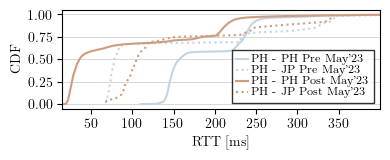

In [66]:
#def plot_cdf(df, cities, column, xlabel,

savefig=""
title="CDF"
city_colors={}
lstyles={}
condition=True
figures_path=result_path
xlim=None
legendsettings={}
legendloc="lower right"

matplotlib.rcParams.update({"font.size": 10})
fig, ax = plt.subplots(figsize=(4, 1.7))

# Philippines->PH Premay
xs = ph_df_premay[ph_df_premay["server_Geo_CountryCode"] == "PH"]["a_MinRTT"].values
xs = sorted(xs)
if len(xs) == 0:
    raise RuntimeError()
ys = np.arange(1, len(xs) + 1) / len(xs)
indices = []
current = xs[0]
for i, x in enumerate(xs): # only take max y value at each x value to smoothen out the graph
    if x != current:
        current = x
        indices.append(i - 1)
indices.append(len(ys) - 1)
xs = sorted(set(xs))
ys = [ys[i] for i in indices]
ax.plot(xs, ys, label="PH - PH Pre May'23", color=cols[0], linestyle=lstyle_array[0])

# Philippines->JP Premay
xs = ph_df_premay[ph_df_premay["server_Geo_CountryCode"] == "JP"]["a_MinRTT"].values
xs = sorted(xs)
if len(xs) == 0:
    raise RuntimeError()
ys = np.arange(1, len(xs) + 1) / len(xs)
indices = []
current = xs[0]
for i, x in enumerate(xs): # only take max y value at each x value to smoothen out the graph
    if x != current:
        current = x
        indices.append(i - 1)
indices.append(len(ys) - 1)
xs = sorted(set(xs))
ys = [ys[i] for i in indices]
ax.plot(xs, ys, label="PH - JP Pre May'23", color=cols[0], linestyle=lstyle_array[1])

# Philippines->PH Postmay
xs = ph_df_postmay[ph_df_postmay["server_Geo_CountryCode"] == "PH"]["a_MinRTT"].values
xs = sorted(xs)
if len(xs) == 0:
    raise RuntimeError()
ys = np.arange(1, len(xs) + 1) / len(xs)
indices = []
current = xs[0]
for i, x in enumerate(xs): # only take max y value at each x value to smoothen out the graph
    if x != current:
        current = x
        indices.append(i - 1)
indices.append(len(ys) - 1)
xs = sorted(set(xs))
ys = [ys[i] for i in indices]
ax.plot(xs, ys, label="PH - PH Post May'23", color=cols[1], linestyle=lstyle_array[0])

# Philippines->JP Postmay
xs = ph_df_postmay[ph_df_postmay["server_Geo_CountryCode"] == "JP"]["a_MinRTT"].values
xs = sorted(xs)
if len(xs) == 0:
    raise RuntimeError()
ys = np.arange(1, len(xs) + 1) / len(xs)
indices = []
current = xs[0]
for i, x in enumerate(xs): # only take max y value at each x value to smoothen out the graph
    if x != current:
        current = x
        indices.append(i - 1)
indices.append(len(ys) - 1)
xs = sorted(set(xs))
ys = [ys[i] for i in indices]
ax.plot(xs, ys, label="PH - JP Post May'23", color=cols[1], linestyle=lstyle_array[1])

ax.set_xlim((15, 400))
ax.set_xlabel("RTT [ms]")
ax.set_ylabel("CDF")
ax.set_yticks(np.arange(0, 1.25, 0.25))
ax.set_xticks(np.arange(50, 400, 50))
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False

ax.legend(loc=legendloc, fontsize="small", ncol=1, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False)
plt.grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)

#plt.title(title)
fig.tight_layout()
plt.savefig(os.path.join(result_path, "fig19_mlab_cdf_rtt_phjp.pdf"), bbox_inches="tight", pad_inches=0)
plt.show()

### Figure 20

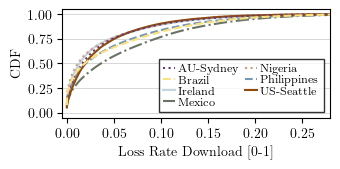

In [67]:
interesting_cities = [
        "Mexico City",
        "São Paulo",
        "Seattle",
        "Sydney",
        "Dublin",
        "Lagos",
        "Manila"
]
interesting_cities=sorted(interesting_cities)
city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}
lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

df = city_df[ 
    city_df["client_Geo_City"].isin(interesting_cities)
]

# Filter out not same city / country
from unidecode import unidecode
df = df[((df["client_Geo_City"].map(unidecode) == df["server_Geo_City"].map(unidecode)) & df["client_Geo_CountryCode"].isin(["US", "AU"])) | (df["client_Geo_CountryCode"] == df["server_Geo_CountryCode"])]

down_df = df[df["isDownload"] == True]
up_df = df[df["isDownload"] == False]

###########################

matplotlib.rcParams.update({"font.size": 10})
plot_cdf(down_df, interesting_cities, "a_LossRate", "Loss Rate Download [0-1]", xlim=(-0.005, 0.28),
             figsize=(3.5, 1.8), city_colors=city_colors, lstyles=lstyles, savefig="fig20_mlab_cdf_lossrate-down_globalcities.pdf", labelmaprule=LABELMAPRULE,
             figures_path=result_path)

### Figure 21

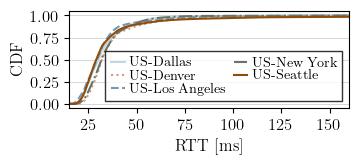

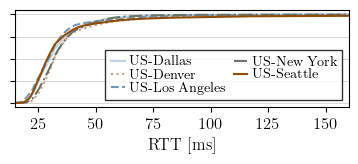

In [68]:
interesting_cities = [
    "Seattle",
    "Denver",
    "Dallas",
    "New York",
    "Los Angeles"
]
interesting_cities = sorted(interesting_cities)

city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}
lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

df = region_filters["NA"](city_df)

matplotlib.rcParams.update({"font.size": 12})
plot_cdf(df[df["isDownload"] == True], interesting_cities, "a_MinRTT", "RTT [ms]", xlim=(15, 160), xticks=[25, 50, 75, 100, 125, 150],
         figsize=(3.75, 1.8), savefig="fig21_mlab_cdf_minrtt_5nacities.pdf", city_colors=city_colors, lstyles=lstyles, labelmaprule=LABELMAPRULE,
         figures_path=result_path)
plot_cdf(df[df["isDownload"] == True], interesting_cities, "a_MinRTT", "RTT [ms]", xlim=(15, 160), ylabel="", stripylabels=True, xticks=[25, 50, 75, 100, 125, 150],
         figsize=(3.75, 1.8), savefig="fig21_mlab_cdf_minrtt_5nacities_stripped.pdf", city_colors=city_colors, lstyles=lstyles, labelmaprule=LABELMAPRULE,
         figures_path=result_path)

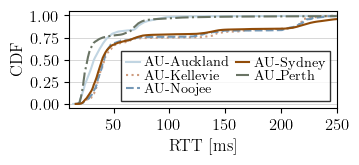

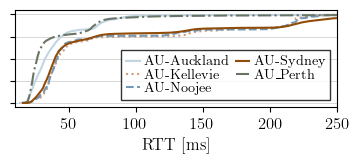

In [69]:
interesting_cities = [
                "Sydney",
                "Perth",
                "Noojee",
                "Kellevie",
                "Auckland"]
interesting_cities = sorted(interesting_cities)

city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}

lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

df = region_filters["AU"](city_df)


matplotlib.rcParams.update({"font.size": 12})
plot_cdf(df[df["isDownload"] == True], interesting_cities, "a_MinRTT", "RTT [ms]",
             figsize=(3.75, 1.8), city_colors=city_colors, lstyles=lstyles, xlim=(10, 250), savefig="fig21_mlab_cdf_minrtt_5aucities.pdf", xticks=[50, 100, 150, 200, 250], labelmaprule=LABELMAPRULE,
             figures_path=result_path)
plot_cdf(df[df["isDownload"] == True], interesting_cities, "a_MinRTT", "RTT [ms]",
             figsize=(3.75, 1.8), city_colors=city_colors, lstyles=lstyles, xlim=(10, 250), ylabel="", stripylabels=True, savefig="fig21_mlab_cdf_minrtt_5aucities_stripped.pdf", xticks=[50, 100, 150, 200, 250], labelmaprule=LABELMAPRULE,
             figures_path=result_path)

## Heatmaps

* Figure 5: Median of minimum RTT (in ms) of devices connected via Starlink (left) and top-3 serving ISPs (right) in the same country to the nearest M-Lab server.
* Figure 17: Median last-mile latency of M-lab measurement. By subtracting traceroute latency from the M-lab server to the PoP and the overall measured min RTT, we get the latency depicted in this figure
* Figure 18: Fraction of the latency, that is estimated to be over the satellite link by dividing the latency of figure 17 with its overall latency.

### Figure 5

In [70]:
import pycountry
import re
import geopandas
import cartopy
import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib.lines import Line2D

countries_name2code = {}
for country in pycountry.countries:
    if re.search("moldova", country.name, re.IGNORECASE):
        #print(country.name)
        countryname = "Moldova"
    elif re.search("saint martin", country.name, re.IGNORECASE):
        #print(country.name)
        countryname = "Saint Martin"
    elif re.search("Virgin Islands, U.S.", country.name, re.IGNORECASE):
        #print(country.name)
        countryname = "U.S. Virgin Islands"
    else:
        countryname = country.name
    countries_name2code[countryname] = country.alpha_2
    
import json
# Country Codes
with open("./iso3.json", mode="r", encoding="utf-8") as file:
    f = json.load(file)
country_codes = {value: key for key, value in f.items()} # create mapping from 2-letter to 3-letter country code

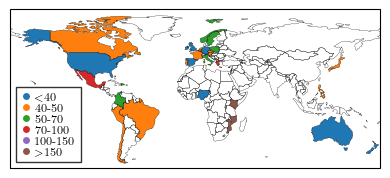

In [71]:
### Generating Example Data
used_df = country_agg_sl_df[country_agg_sl_df["count_measurements"] > 500].reset_index()
used_df = used_df[used_df["CountryName"].isin(countries)]
example_country_data = {countries_name2code[row["CountryName"]]: row["median_minrtt"]  for _, row in used_df.iterrows()}

### Plotting Example Data in Map

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")] # remove Antarctica
    
country_data = []
for name, code in zip(world["name"], world["iso_a3"]):    
    if name == "France":
        country_data.append(example_country_data[country_codes["FRA"]])
    elif name == "Norway":
        country_data.append(example_country_data[country_codes["NOR"]])
    elif code in country_codes and country_codes[code] in example_country_data:
        country_data.append(example_country_data[country_codes[code]])
    else:
        country_data.append(float("NaN"))
world["data"] = country_data

matplotlib.rcParams.update({"font.size": 10})
fig, ax = plt.subplots(figsize=(4, 2), subplot_kw={'projection': ccrs.PlateCarree()})

labels = ["$<$40", "40-50", "50-70", "70-100", "100-150", "$>$150"]
cmap = "tab10"
cols = plt.get_cmap("tab10").colors[:6]
cmap = colors.ListedColormap(cols)
handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor=col)
           for col in cols]
ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="lower left", fancybox=False, edgecolor="k", fontsize="small")

world.plot(facecolor ="#00000000", ax=ax, edgecolor="black", linewidth=0.2)
world.plot(column="data", cmap=cmap, scheme='UserDefined', 
           classification_kwds=dict(bins=[40,50,70,100, 150, 99999999]), zorder=0, ax=ax)
ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.tight_layout()
plt.savefig(f"{result_path}/fig05_mlab_mapped_medianminrtt_heatmap.pdf", bbox_inches="tight", pad_inches=0)
plt.savefig(f"{result_path}/fig05_mlab_mapped_medianminrtt_heatmap.svg", bbox_inches="tight", pad_inches=0)
plt.show()

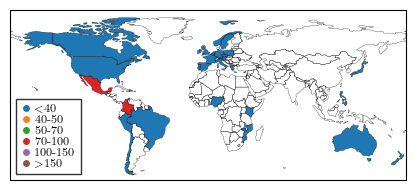

In [72]:
### Generating Example Data
used_df = country_agg_topmno_df[country_agg_topmno_df["count_measurements"] > 500]
used_df = used_df[used_df["CountryName"].isin(countries)]
used_df = used_df[~used_df["CountryName"].isin(["Martinique", "Saint Barthélemy"])]
example_country_data = {countries_name2code[row["CountryName"]]: row["median_minrtt"]  for _, row in used_df.iterrows()}

### Plotting Example Data in Map

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")] # remove Antarctica
    
country_data = []
for name, code in zip(world["name"], world["iso_a3"]):    
    if name == "France":
        country_data.append(example_country_data[country_codes["FRA"]])
    elif name == "Norway":
        country_data.append(example_country_data[country_codes["NOR"]])
    elif code in country_codes and country_codes[code] in example_country_data:
        country_data.append(example_country_data[country_codes[code]])
    else:
        country_data.append(float("NaN"))
world["data"] = country_data

fig, ax = plt.subplots(figsize=(4.66, 2), subplot_kw={'projection': ccrs.PlateCarree()})

labels = ["$<$40", "40-50", "50-70", "70-100", "100-150", "$>$150"]
cmap = "tab10"
cols = plt.get_cmap("tab10").colors[:6]
cmap = colors.ListedColormap(cols)
handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor=col)
           for col in cols]
ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="lower left", fancybox=False, edgecolor="k", fontsize="small")

world.plot(facecolor ="#00000000", ax=ax, edgecolor="black", linewidth=0.2)
world.plot(column="data", cmap=cmap, scheme='UserDefined', 
           classification_kwds=dict(bins=[40,50,70,100, 150, 99999999]), zorder=0, ax=ax)
ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.tight_layout()
# The bins have been manually editted, ....
plt.savefig(f"{result_path}/mlab_mnocell-all_mapped_medianminrtt_heatmap.pdf", bbox_inches="tight", pad_inches=0)
plt.savefig(f"{result_path}/mlab_mnocell-all_mapped_medianminrtt_heatmap.svg", bbox_inches="tight", pad_inches=0)
plt.show()

### Figure 17

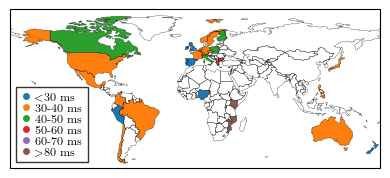

In [73]:
### Generating Example Data

used_df = trace_tput_df[["countryC", "median_stl_rtt"]].groupby("countryC").mean()
example_country_data = {code: row["median_stl_rtt"]  for code, row in used_df.iterrows()}

#print(example_country_data)
### Plotting Example Data in Map

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")] # remove Antarctica
    
country_data = []
for name, code in zip(world["name"], world["iso_a3"]):    
    if name == "France":
        country_data.append(example_country_data[country_codes["FRA"]])
    elif name == "Norway":
        country_data.append(example_country_data[country_codes["NOR"]])
    elif code in country_codes and country_codes[code] in example_country_data:
        country_data.append(example_country_data[country_codes[code]])
    else:
        country_data.append(float("NaN"))
world["data"] = country_data

matplotlib.rcParams.update({"font.size": 10})
fig, ax = plt.subplots(figsize=(4, 2), subplot_kw={'projection': ccrs.PlateCarree()})

#labels = ["$<$40", "40-50", "50-70", "70-100", "100-150", "$>$150"]
#labels = ["$<$25", "25-35", "35-40","40-50", "50-60", "60-80", "$>$80"]
classification_bins = [30,40,50,60, 70, 80, 99999999]
def label_gen(suffix=""):
    labels = []
    for i, n in enumerate(classification_bins):
        if i == 0:
            labels.append(f"$<${n}{suffix}")
        elif i == len(classification_bins) - 2:
            labels.append(f"$>${n}{suffix}")
            break
        else:
            labels.append(f"{classification_bins[i-1]}-{n}{suffix}")
    return labels
labels = label_gen(suffix=" ms")
cmap = "tab10"
cols = plt.get_cmap("tab10").colors[:len(labels)]
cmap = colors.ListedColormap(cols)
handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor=col)
           for col in cols]
ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="lower left", fancybox=False, edgecolor="k", fontsize="small")

world.plot(facecolor ="#00000000", ax=ax, edgecolor="black", linewidth=0.2)
world.plot(column="data", cmap=cmap, scheme='UserDefined', 
           classification_kwds=dict(bins=classification_bins), zorder=0, ax=ax)
ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.tight_layout()
plt.savefig(f"{result_path}/fig17_mlab_median-starlink-rtt_heatmap.pdf", bbox_inches="tight", pad_inches=0)
plt.savefig(f"{result_path}/fig17_mlab_median-starlink-rtt_heatmap.svg", bbox_inches="tight", pad_inches=0)
plt.show()

### Figure 18

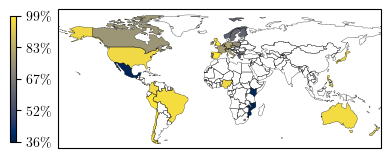

In [74]:
### Generating Example Data

used_df = trace_tput_df[["countryC", "median_stl_rtt_fraction"]].groupby("countryC").mean()
example_country_data = {code: (row["median_stl_rtt_fraction"] - min(used_df["median_stl_rtt_fraction"] )) / (max(used_df["median_stl_rtt_fraction"]) - min(used_df["median_stl_rtt_fraction"]))  for code, row in used_df.iterrows()}

### Plotting Example Data in Map

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")] # remove Antarctica
    
country_data = []
for name, code in zip(world["name"], world["iso_a3"]):    
    if name == "France":
        country_data.append(example_country_data[country_codes["FRA"]])
    elif name == "Norway":
        country_data.append(example_country_data[country_codes["NOR"]])
    elif code in country_codes and country_codes[code] in example_country_data:
        country_data.append(example_country_data[country_codes[code]])
    else:
        country_data.append(float("NaN"))
world["data"] = country_data

matplotlib.rcParams.update({"font.size": 10})
fig, ax = plt.subplots(figsize=(4.8, 2.4), subplot_kw={'projection': ccrs.PlateCarree()})

#labels = ["$<$40", "40-50", "50-70", "70-100", "100-150", "$>$150"]
#labels = ["$<$25", "25-35", "35-40","40-50", "50-60", "60-80", "$>$80"]
classification_bins = np.linspace(0, 100, 100)
def label_gen(suffix = ""):
    labels = []
    for i, n in enumerate(classification_bins):
        if i == 0:
            labels.append(f"$<${n}{suffix}")
        elif i == len(classification_bins) - 2:
            labels.append(f"{classification_bins[i-1]}-{n}{suffix}")
            break
        else:
            labels.append(f"{classification_bins[i-1]}-{n}{suffix}")
    return labels
labels = label_gen(suffix = " \%")
#cmap = "tab10"
#cols = plt.get_cmap("tab10").colors[:len(labels)]
#cols = plt.get_cmap("rainbow").colors[:len(labels)]
#cmap = colors.ListedColormap(cols)
cmap = matplotlib.colormaps["cividis"]
#cmap = 'gray'
handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor=col)
           for col in cols]
#ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
#          loc="lower left", fancybox=False, edgecolor="k", fontsize="small")

world.plot(facecolor ="#00000000", ax=ax, edgecolor="black", linewidth=0.2)
asd = world.plot(column="data", cmap=cmap, zorder=0, ax=ax)

#plt.colorbar(ax=ax, cmap=cmap)
cmap_abs_range = np.linspace(min(used_df["median_stl_rtt_fraction"]), max(used_df["median_stl_rtt_fraction"]), 5)
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=None, cmap=cmap), ax=asd, shrink=0.6, anchor=(-7.2, 0.5))
cbar.set_ticks(ticks=np.linspace(0, 1, len(cmap_abs_range)), labels=[f"{int(n)}\%" for n in cmap_abs_range])

ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.tight_layout()
plt.savefig(f"{result_path}/mlab_median-starlink-rtt-fraction_heatmap.pdf", bbox_inches="tight", pad_inches=0)
plt.savefig(f"{result_path}/mlab_median-starlink-rtt-fraction_heatmap.svg", bbox_inches="tight", pad_inches=0)
plt.show()

## Maps

* Figure 1: Orbits of three Starlink inclinations and crowdsourced Ground Station (GS) and Point-of-Presence (PoP) locations. Shaded regions depict Starlink’s service area.

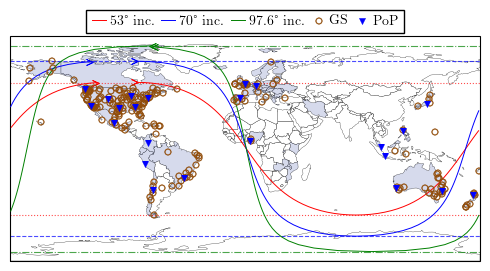

In [75]:
from geospatial_plot_utils import get_coords, plot_period_groundtrack

continents = ["AF", "AS", "EU", "NA", "OC", "SA"]
cols = ["#c1d5e2", "#ce9c7f", "#7598b6", "#6a7465", "#914c09", "#663979", "#fbe17b"]

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(5, 2.8), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = colors.ListedColormap(cols[:-2])
world.plot(facecolor = "white", edgecolor="black", ax=ax, linewidth=0.2)



def plotCountryPatch( axes, country_name, fcolor ):
    # plot a country on the provided axes
    nami = world[world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.2, zorder=2, linewidth=0.0 ))

for c in countries:
    c = "United States of America" if c == "United States" else c
    c = "Czechia" if c == "Czech Republic" else c
    
    if(c in world["name"].values):
        plotCountryPatch(ax, c, "#364aa0")

begin_time = 1679408909

coords, bc1, bc2 = get_coords( 53, 238, 550, 100, begin_time, portion=1)
plot_period_groundtrack(coords,  ax, "red", label="53° inc.")
to_scatter = [coords[0], coords[-1]]
ax.scatter(
            [latlon[1] - 2 for latlon in to_scatter],
            [latlon[0] for latlon in to_scatter], 
            marker='$>$', zorder=10, color="red", sizes=[30.0], linewidth=0.5)
#plot_bounds(bc1_40, bc2_40, ax, "#436abc48")

coords, bc1, bc2 = get_coords( 70, 238, 570, 100, begin_time, portion=1)
plot_period_groundtrack(coords, ax, "blue", label="70° inc.")
to_scatter = [coords[0], coords[-1]]
ax.scatter(
            [latlon[1] - 2 for latlon in to_scatter],
            [latlon[0] for latlon in to_scatter], 
            marker='$>$', zorder=10, color="blue", sizes=[30.0], linewidth=0.5)
#plot_bounds(bc1_80, bc2_80, ax, "#9cd37a48")

coords, bc1, bc2 = get_coords( 97.6, 70, 560, 100, begin_time, portion=1)
plot_period_groundtrack(coords, ax, "green", label="97.6° inc.")
to_scatter = [coords[0], coords[-1]]
ax.scatter(
            [latlon[1] for latlon in to_scatter],
            [latlon[0] for latlon in to_scatter], 
            marker='$<$', zorder=10, color="green", sizes=[30.0], linewidth=0.5)

#coords_80, bc1_80, bc2_80 = get_coords( 98, 238, 500, 100, begin_time)
#plot_period_groundtrack(coords_80, ax, "green", label="75° inclination")
#plot_bounds(bc1_80, bc2_80, ax, "#9cd37a48")
    
def plot_extent(inclination, color="r", lw=1.4, alpha=0.7, lt="dotted"):
    #label = "{}°".format(inclination)
    label=""
    if inclination > 90:
        inclination = 90 - (inclination % 90)
    plt.plot([-180, 180], [ inclination,  inclination], linewidth=lw, color=color, linestyle=lt, alpha=alpha, label=label)
    plt.plot([-180, 180], [-inclination, -inclination], linewidth=lw, color=color, linestyle=lt, alpha=alpha)

plot_extent(53, "r", lt="dotted", lw=0.8)
plot_extent(70, "b", lt="dashed", lw=0.8)
plot_extent(97.6, "g", lt="dashdot", lw=0.8)


# Plotting GS points
def plot_gsdata(gsdata_df, ax, label, marker, color, size=10, lw=0.6):
    latitude, longitude = gsdata_df["lat"], gsdata_df["long"]
    ax.scatter(longitude, latitude,
               sizes = [size],
               color=color,
               zorder = 10,
               marker=marker,
               linewidth = lw,
               label=label)
 
    
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

#ax2.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
#ax2.get_xaxis().set_ticks([])
#ax2.get_yaxis().set_ticks([])

#legend1 = plt.legend(plot_lines[0], ["algo1", "algo2", "algo3"], loc=1)
#pyplot.legend([l[0] for l in plot_lines], parameters, loc=4)

#ax2 = ax.twinx()
plot_gsdata(gateway_df, ax, "GS", "$\circ$", cols[4], 30, lw=0.3)
plot_gsdata(pop_df, ax, "PoP", "v", "blue", 20, lw=0.3)

#plt.legend(loc='upper right', bbox_to_anchor=(1.01, 1.03),
#          ncol=1, fancybox=True, shadow=False, framealpha = 1.0)
ax.legend(loc='upper center', bbox_to_anchor=(0.50, 1.15),
        ncol=5, edgecolor="k", handlelength=1, labelspacing=0.06, 
        columnspacing=0.5, fancybox=False, shadow=False, handletextpad = 0.3, framealpha = 1.0).set_zorder(100)
#ax2.legend(loc='lower left',
#        ncol=1, edgecolor="k", handlelength=1, labelspacing=0.06, 
#        columnspacing=0.5, fancybox=False, shadow=False, handletextpad = 0.3, framealpha = 1.0).set_zorder(100)

#ax.legend(loc="upper center", bbox_to_anchor=(0.50, 1.25), frameon=False, shadow=False,
#              ncol=5,
#              labelspacing=0.3, handlelength=1.2, handletextpad=0.4, columnspacing=1.2)

plt.axis('tight')
plt.tight_layout()
plt.savefig(f"{result_path}/inclination_starlink_comparison_with_gws.pdf", bbox_inches="tight", pad_inches=0)
plt.savefig(f"{result_path}/inclination_starlink_comparison_with_gws.svg", bbox_inches="tight", pad_inches=0)
plt.show()

## Evolution over Time

* Figure 23: Evolution of Starlink aggregate goodput ((a), (b)) and minimum RTT (c) during download measurements from cities in South America, North America, Europe, and Australia in the last 12 months.

In [76]:
interesting_cities = [
        "Mexico City",
        "São Paulo",
        "Seattle",
        "Sydney",
        "Dublin",
        "Lagos",
        "Manila"
]
interesting_cities=sorted(interesting_cities)
city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}
lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

df = city_df[ 
    city_df["client_Geo_City"].isin(interesting_cities)
]

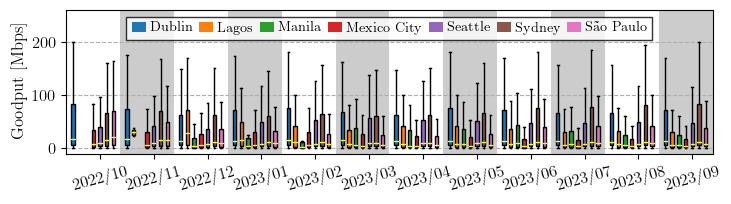

In [77]:
matplotlib.rcParams.update({"font.size": 12})
months_array = df[["a_TestMonth"]].drop_duplicates().sort_values("a_TestMonth")["a_TestMonth"]
datetime_array = [datetime.fromisoformat(str(dt_str)) for dt_str in months_array]
data_array = [
    {c: df[(df["client_Geo_City"] == c) & (df["a_TestMonth"] == month)]["GoodputMedian"]
         for c in interesting_cities} for month in months_array
]

# Mean throughput
plot_boxplot_progression(datetime_array[-12:], data_array[-12:],
                              figsize=(7.5, 2.2),
                              ylim=(-10, 260),
                              figures_path=result_path,
                              nlegendcols=7,
                              savefig="mlab_throughput_globalcities_2022-10_to_2023-09.pdf",
                              ylabel="Goodput [Mbps]",
                              orientation="upper center"
                        )

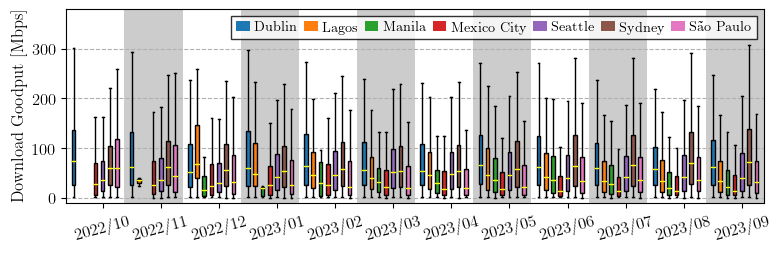

In [78]:
months_array = df[["a_TestMonth"]].drop_duplicates().sort_values("a_TestMonth")["a_TestMonth"]
datetime_array = [datetime.fromisoformat(str(dt_str)) for dt_str in months_array]
data_array = [
    {c: down_df[(down_df["client_Geo_City"] == c) & (down_df["a_TestMonth"] == month)]["GoodputMedian"]
         for c in interesting_cities} for month in months_array
]

# Mean throughput
plot_boxplot_progression(datetime_array[-12:], data_array[-12:],
                            figsize=(8, 2.7),
                            figures_path=result_path,
                         ylim=(-10, 380),
                             nlegendcols=7,
                             savefig="mlab_goodputmedian-down_globalcities_2022-10_to_2023-09.pdf", ylabel="Download Goodput [Mbps]",
                             orientation="upper right"
                        )

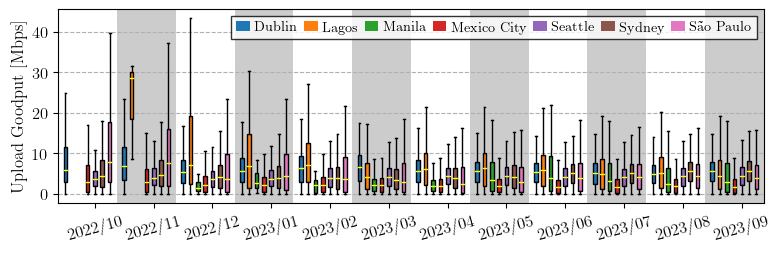

In [79]:
months_array = df[["a_TestMonth"]].drop_duplicates().sort_values("a_TestMonth")["a_TestMonth"]
datetime_array = [datetime.fromisoformat(str(dt_str)) for dt_str in months_array]
data_array = [
    {c: up_df[(up_df["client_Geo_City"] == c) & (up_df["a_TestMonth"] == month)]["GoodputMedian"]
         for c in interesting_cities} for month in months_array
]

# Mean throughput
plot_boxplot_progression(datetime_array[-12:], data_array[-12:],
                            figsize=(8, 2.7),
                            figures_path=result_path,
                             nlegendcols=7,
                             savefig="mlab_goodputmedian-up_globalcities_2022-10_to_2023-09.pdf", ylabel="Upload Goodput [Mbps]",
                             orientation="upper right"
                        )

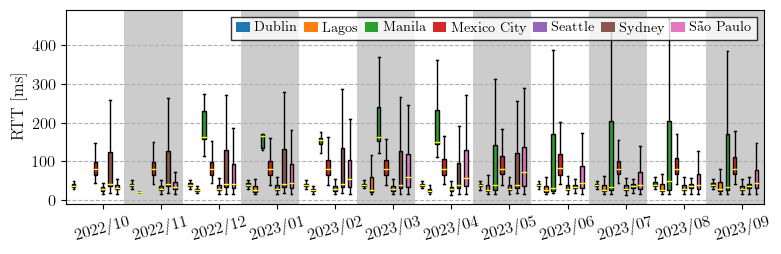

In [80]:
months_array = df[["a_TestMonth"]].drop_duplicates().sort_values("a_TestMonth")["a_TestMonth"]
datetime_array = [datetime.fromisoformat(str(dt_str)) for dt_str in months_array]
data_array = [
    {c: down_df[(down_df["client_Geo_City"] == c) & (down_df["a_TestMonth"] == month)]["a_MinRTT"]
         for c in interesting_cities} for month in months_array
]

# MinRTT
plot_boxplot_progression(datetime_array[-12:], data_array[-12:],
                            figsize=(8, 2.7),
                            figures_path=result_path,
                             nlegendcols=7,
                             savefig="mlab_minrtt_globalcities_2022-10_to_2023-09.pdf", ylabel="RTT [ms]",
                             orientation="upper right"
                        )